In [19]:
from detectron2.config import get_cfg
from detectron2.data import build_detection_train_loader
import matplotlib.pyplot as plt
import torch.nn.functional as F

from coseg.data.dataset_mappers import TrainMapper

In [20]:
registered_datasets = MetadataCatalog.list()
print("Registered Datasets:", registered_datasets)

Registered Datasets: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem

In [2]:
cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file('./configs/base_config.yaml')

Loading config ./configs/base_config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [4]:
dataloader = build_detection_train_loader(
    cfg,
    mapper=TrainMapper(cfg, True),
)

In [8]:
it = iter(dataloader)
batch = next(it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7484672..2.145897].


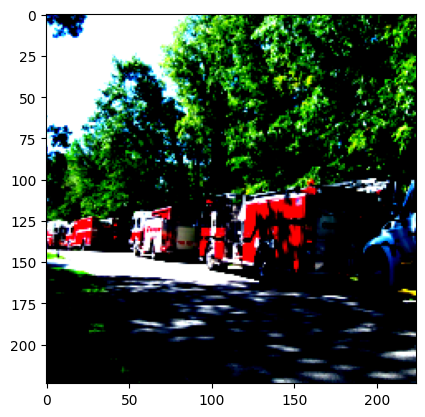

In [9]:
plt.imshow(batch[0]['image'].permute(1, 2, 0))

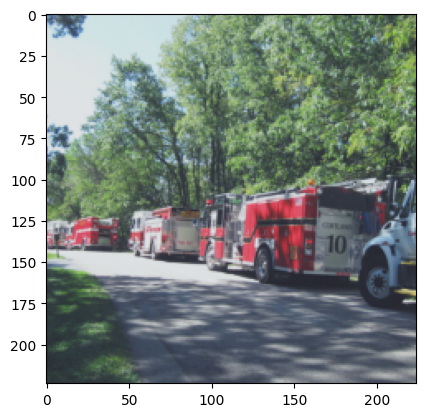

In [10]:
plt.imshow(F.sigmoid(batch[0]['image'].permute(1, 2, 0)))

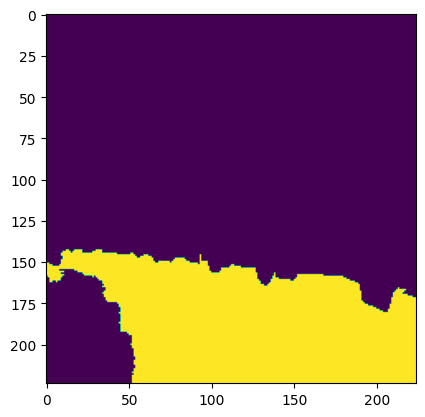

In [23]:
plt.imshow(batch[0]['masks'][1])

In [12]:
batch[0]['ids']

[157,
 137,
 7,
 112,
 145,
 120,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255]

In [13]:
from detectron2.data import MetadataCatalog

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

In [14]:
[metadata.stuff_classes[id] for id in batch[0]['ids'] if id != 255]

['tree', 'road', 'truck', 'grass', 'sky-other', 'metal']

In [15]:
len(metadata.stuff_classes)

171

In [16]:
metadata.stuff_classes[0]

'person'

In [17]:
[1] * 0

[]

In [18]:
cfg.INPUT.IGNORE_VALUE

255